For this exercise, we will compare the methods for finding linear models on a real-world data set for housing prices in California, where we assume most of you will locate your start-ups.  

The data set we will use is based on data studied in Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.  

The following description is copied from: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

- This dataset was obtained from the StatLib repository. https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

- The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

- This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

- An household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts.

It is known that there are some outliers in the data set (discussed in https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) using raw features.  

To keep the work simple, for this assignment we will not inspect the data or transform it beyond standardization.    With more time, we could use domain knowledge or experimentation to transform the features in the data set, such as trying a log scale for occupancy, for instance.

In [21]:
import numpy as np
#Initialize a random number generator
#pass an integer if you want results to be reproducible
rng = np.random.RandomState() 

import matplotlib.pyplot as plt  #plotting library
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
scoring_func = make_scorer(mean_squared_error,greater_is_better=False)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_california_housing

from itertools import combinations
from more_itertools import powerset
import operator

## Load the data set

In [22]:
use_pd = False

if use_pd:
    # As a data frame
    housing = fetch_california_housing(as_frame=True)
else:    
    # As Numpy arrays
    housing = fetch_california_housing(as_frame=False)

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [23]:
X = housing.data

print('\nThe first 5 sample values for the 8 features:')
if use_pd:
    X.head() #print the top of the data frame
else:
    print(X[:5,])


The first 5 sample values for the 8 features:
[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   4.96000000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02]
 [ 3.84620000e+00  5.20000000e+01  6.28185328e+00  1.08108108e+00
   5.65000000e+02  2.18146718e+00  3.78500000e+01 -1.22250000e+02]]


In [24]:
y = housing.target
print('\nThe first 5 sample values of Y:')

if use_pd:
    y.head() #print the top of the data frame
else:
    print(y[:5])


The first 5 sample values of Y:
[4.526 3.585 3.521 3.413 3.422]


### Create a training set and a test set

We will later use the training set with cross validation (picking hold out sets for picking hyper-parameters).

The test set we will save until the very end.

There are 20640 samples total. Initially, we will use a small set for training.



In [25]:
#Split up the big data set into a test set (for final evaluation) and a training set
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=100, random_state=1)

Print out (X's are Pandas data frames) the values -- make sure it shuffled

In [26]:
X_train

array([[ 3.50390000e+00,  1.90000000e+01,  5.02336449e+00,
         1.11915888e+00,  1.05200000e+03,  2.45794393e+00,
         3.64800000e+01, -1.21700000e+02],
       [ 2.34380000e+00,  1.80000000e+01,  4.97039474e+00,
         1.03618421e+00,  1.06200000e+03,  3.49342105e+00,
         3.86100000e+01, -1.21480000e+02],
       [ 3.41910000e+00,  5.20000000e+01,  4.53061224e+00,
         8.16326531e-01,  1.10700000e+03,  1.12959184e+01,
         3.97300000e+01, -1.21850000e+02],
       [ 2.00000000e+00,  4.40000000e+01,  5.05333333e+00,
         1.04444444e+00,  7.47000000e+02,  3.32000000e+00,
         3.39200000e+01, -1.18250000e+02],
       [ 2.06250000e+00,  6.00000000e+00,  4.72053872e+00,
         9.78114478e-01,  2.80700000e+03,  4.72558923e+00,
         3.26700000e+01, -1.15520000e+02],
       [ 5.18400000e+00,  3.50000000e+01,  6.04175365e+00,
         9.74947808e-01,  1.42000000e+03,  2.96450939e+00,
         3.40600000e+01, -1.17920000e+02],
       [ 3.31250000e+00,  4.300000

In [27]:
y_train

array([2.884  , 0.894  , 1.375  , 0.926  , 0.677  , 2.249  , 1.5    ,
       3.045  , 3.205  , 3.25   , 2.417  , 1.113  , 1.878  , 1.831  ,
       1.551  , 1.372  , 0.859  , 1.257  , 5.00001, 1.813  , 1.33   ,
       1.843  , 1.294  , 1.375  , 5.00001, 1.753  , 1.406  , 1.789  ,
       5.00001, 1.411  , 1.154  , 3.649  , 2.456  , 2.951  , 1.05   ,
       1.475  , 2.77   , 1.889  , 1.464  , 3.31   , 2.044  , 1.572  ,
       3.198  , 1.524  , 1.982  , 1.262  , 2.453  , 3.455  , 4.023  ,
       1.4    , 0.433  , 0.942  , 3.585  , 1.142  , 0.734  , 2.671  ,
       2.48   , 1.589  , 1.441  , 0.517  , 1.51   , 1.139  , 3.508  ,
       2.673  , 1.405  , 5.00001, 2.184  , 3.648  , 0.741  , 0.958  ,
       2.399  , 1.479  , 1.894  , 0.689  , 1.81   , 1.077  , 5.00001,
       1.931  , 4.102  , 1.291  , 5.00001, 1.57   , 0.546  , 2.278  ,
       0.938  , 1.75   , 0.668  , 1.941  , 2.528  , 1.612  , 1.308  ,
       0.575  , 2.331  , 1.46   , 1.846  , 2.053  , 5.00001, 1.048  ,
       1.407  , 1.26

In [140]:
housing.feature_names[1]

'HouseAge'

In [13]:
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(housing.feature_names) if abs(item) > 0]

# Model Fitting

#### Let's first fit using no features (just the intercept $\beta_0$) and all the features ( OLS or Ordinary Least Squares solution)

The intercept:

In [28]:
#Train MSE
y_pred = np.ones(y_train.shape)*(np.mean(y_train))
mse_train_just_intercept = mean_squared_error(y_train,y_pred)

y_pred = np.ones(y_test.shape)*(np.mean(y_train))
mse_test_just_intercept = mean_squared_error(y_test,y_pred)

print('\nTraining set MSE using only the intercept: %.2f'%mse_train_just_intercept)
print('\nTest set MSE using only the intercept: %.2f'%mse_test_just_intercept)


Training set MSE using only the intercept: 1.36

Test set MSE using only the intercept: 1.33


The OLS solution:

In [29]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)

# Train MSE
mse_train_OLS = mean_squared_error(y_train, pipe.predict(X_train))

#Test MSE
mse_test_OLS = mean_squared_error(y_test, pipe.predict(X_test))

print('\nTraining set MSE using OLS solution: %.2f'%mse_train_OLS)
print('\nTest set MSE using OLS solution: %.2f'%mse_test_OLS)


Training set MSE using OLS solution: 0.36

Test set MSE using OLS solution: 1.46


#### OLS - CV
For reference on the lasso and ridge regression plots, which will be using cross-validation, also calculate the CV hold out MSE using OLS

In [31]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)

parameters = {}
n_folds=5
gs = GridSearchCV(pipe, parameters, \
                  scoring='neg_mean_squared_error', \
                  cv=n_folds)
gs.fit(X_train,y_train)

scores = -gs.cv_results_['mean_test_score']
scores_std = gs.cv_results_['std_test_score']

mse_train_OLS_CV = scores[0] 
#each entry for different parameter, but no paramters passed, so just first entry

print('\nTraining set MSE using OLS solution: %.2f'%mse_train_OLS_CV)


CVTraining set MSE using OLS solution: 0.55


# Ordinary Least Squares

In [44]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(X_train,y_train)
mse_test_OLS = mean_squared_error(y_test, pipe.predict(X_test))

print('\nTest set MSE using OLS solution: %.2f'%mse_test_OLS)


Test set MSE using OLS solution: 1.46


In [175]:
cols = list(housing.feature_names)
print('Subset of features in OLS:')
print(cols)

Subset of features in OLS:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Best Intercept

In [322]:
y_pred = np.ones(y_test.shape)*(np.mean(y_train))
mse_test_best_intercept = mean_squared_error(y_test,y_pred)

print('\nTest set MSE using Best Intercept: %.2f'%mse_test_best_intercept)


Test set MSE using Best Intercept: 1.33


In [177]:
print('\nBest Intercept used zero features')
cols = list()
print('Subset of features in Best Intercept:')
print(cols)


Best Intercept used zero features
Subset of features in Best Intercept:
[]


#  Lasso

In [347]:
n_folds = 5 #number of folds
 
n_alphas = 200  #how many lambdas to check
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

parameters = { 'lasso__alpha':alphas}
scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)

lgs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)#grid search
lgs.fit(X_train,y_train)

best_alpha = lgs.best_params_['lasso__alpha'] #get best alpha

scaler = StandardScaler()
lasso = Lasso(alpha=best_alpha,normalize=False,fit_intercept=True)#pass through best alpha
pipe = make_pipeline(scaler, lasso)
pipe.fit(X_train, y_train)

best_coef_lassos = pipe.named_steps['lasso'].coef_ #get coeffiecent values


y_pred = pipe.predict(X_test)
mse_test_using_lasso = mean_squared_error(y_test,y_pred)

print('\nTest set MSE using Lasso : %.2f'%mse_test_using_lasso)


Test set MSE using Lasso : 3.28


In [203]:
cols = list()
rn = range(len(housing.feature_names))
for i in rn:
    if abs(best_coef_lassos[i]) > 0:
        cols.append(housing.feature_names[i])

print('Subset of features in Lasso:')
print(cols)

Subset of features in Lasso:
['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']


# Ridge -- model fit

In [348]:
n_folds = 5 #number of folds
n_alphas = 200 #number of lambdas to check
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

scaler = StandardScaler()
ridge = Ridge(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, ridge)
parameters = { 'ridge__alpha':alphas}
coefs = []

for a in alphas:
    pipe.set_params(ridge__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)
    
rgs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)#grid search for lambda
rgs.fit(X_train,y_train)

best_coef_ridge = pipe.named_steps['ridge'].coef_

y_pred = rgs.predict(X_test)
mse_test_using_ridge = mean_squared_error(y_test,y_pred)
print('\nTest set MSE using Ridge: %.2f'%mse_test_using_ridge)


Test set MSE using Ridge: 2.89


In [208]:
cols = list()
rn = range(len(housing.feature_names))
for i in rn:
    if abs(best_coef_ridge[i]) > 0:
        cols.append(housing.feature_names[i])

print('Subset of features in Ridge:')
print(cols)

Subset of features in Ridge:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Exhaustive search (best subset search)

In [229]:
p = X_train.shape[1] #the number of columns
list_features = range(1,p+1)

In [302]:
model = make_pipeline(StandardScaler(), LinearRegression())

#keep a dictionary, with key as the cardinality and value as 
#  a dictionary with values 'features' (list) and 'trainMSE' (float)
#  initialize with empty set (intercept), calculated above
subsets = {}
subsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = X_train[:,c]
    
        model.fit(a,y_train)
        m = mean_squared_error(y_train, model.predict(a))

n_train_samples = X_train.shape[0]
noise_var_estimate = m
    
for subset in powerset(list_features):
       
    if len(subset)==0:
        subsets[0]['AICpenalty'] = 0
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in subset) #adjust indexing
    
    X_train_subset = X_train[:,cols]
    X_test_subset = X_test[:,cols]
    
    model.fit(X_train_subset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(y_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(subset)
    
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    
    if k not in list(subsets.keys()):
        #add as currently best
        subsets[k] = {'features':subset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if subsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            subsets[k] = {'features':subset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
            

In [303]:
for k in range(p+1):
    subset = subsets[k]['features']
    mse_test = subsets[k]['testMSE']
    AIC_penalty= subsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(subset)), end='')   
    for i in subset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.72   0.01  (1,) (MedInc )

  2  0.67   0.01  (1, 2) (MedInc HouseAge )

  3  0.93   0.02  (1, 2, 3) (MedInc HouseAge AveRooms )

  4  0.65   0.03  (1, 2, 3, 4) (MedInc HouseAge AveRooms AveBedrms )

  5  0.67   0.04  (1, 2, 3, 4, 5) (MedInc HouseAge AveRooms AveBedrms Population )

  6  4.62   0.04  (1, 2, 3, 4, 5, 6) (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  4.93   0.05  (1, 2, 3, 4, 5, 6, 7) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  1.46   0.06  (1, 2, 3, 4, 5, 6, 7, 8) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


# Forward search 

In [304]:
model = make_pipeline(StandardScaler(), LinearRegression())
fsubsets = {}
fsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = X_train[:,c]
    
        model.fit(a,y_train)
        m = mean_squared_error(y_train, model.predict(a))

n_train_samples = X_train.shape[0]
noise_var_estimate = m

for fsubset in powerset(list_features):
       
    if len(fsubset)==0:
        fsubsets[0]['AICpenalty'] = 0
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in fsubset) #adjust indexing
    
    X_train_subset = X_train[:,cols]
    X_test_subset = X_test[:,cols]
    
    model.fit(X_train_subset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(y_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(fsubset)
    if(k>1):
        l = list(fsubset)
        prev = list(fsubsets[k-1]['features'])
        check =  all(item in l for item in prev)
        if(not check):
            continue
            
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    
    if k not in list(fsubsets.keys()):
        #add as currently best
        fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if fsubsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}

In [305]:
for k in range(p+1):
    fsubset = fsubsets[k]['features']
    mse_test = fsubsets[k]['testMSE']
    AIC_penalty= fsubsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(fsubset)), end='')   
    for i in fsubset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.72   0.01  (1,) (MedInc )

  2  0.67   0.01  (1, 2) (MedInc HouseAge )

  3  0.93   0.02  (1, 2, 3) (MedInc HouseAge AveRooms )

  4  0.65   0.03  (1, 2, 3, 4) (MedInc HouseAge AveRooms AveBedrms )

  5  0.67   0.04  (1, 2, 3, 4, 5) (MedInc HouseAge AveRooms AveBedrms Population )

  6  4.62   0.04  (1, 2, 3, 4, 5, 6) (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  4.93   0.05  (1, 2, 3, 4, 5, 6, 7) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  1.46   0.06  (1, 2, 3, 4, 5, 6, 7, 8) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


# Backward search

In [306]:
def rpowerset_generator(it, rev=False):
    rn = range(len(it), 0, -1) if rev else range(1, len(it) + 1)
    for r in rn:
        yield from map(list,combinations(it, r))

In [312]:
bsubsets = {}
bsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = X_train[:,c]
    
        model.fit(a,y_train)
        m = mean_squared_error(y_train, model.predict(a))

n_train_samples = X_train.shape[0]
noise_var_estimate = m



for bsubset in rpowerset_generator(list_features, True):
       
    if len(bsubset)==0:
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in bsubset) #adjust indexing
    
    X_train_subset = X_train[:,cols]
    X_test_subset = X_test[:,cols]
    
    model.fit(X_train_subset,y_train)
    mse_train = mean_squared_error(y_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(y_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(bsubset)
    if(k<p):
        prev = list(bsubsets[k+1]['features'])
        l = list(bsubset)
        check = all(item in prev for item in l)
        if(not check):
            continue
            
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
            
    if k not in list(bsubsets.keys()):
        #add as currently best
        bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if bsubsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
            
bsubsets[0]['AICpenalty'] = 0

In [313]:
for k in range(p+1):
    bsubset = bsubsets[k]['features']
    mse_test = bsubsets[k]['testMSE']
    AIC_penalty= bsubsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(bsubset)), end='')   
    for i in bsubset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.72   0.01  [1] (MedInc )

  2  0.67   0.01  [1, 2] (MedInc HouseAge )

  3  0.93   0.02  [1, 2, 3] (MedInc HouseAge AveRooms )

  4  0.65   0.03  [1, 2, 3, 4] (MedInc HouseAge AveRooms AveBedrms )

  5  0.67   0.04  [1, 2, 3, 4, 5] (MedInc HouseAge AveRooms AveBedrms Population )

  6  4.62   0.04  [1, 2, 3, 4, 5, 6] (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  4.93   0.05  [1, 2, 3, 4, 5, 6, 7] (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  1.46   0.06  [1, 2, 3, 4, 5, 6, 7, 8] (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


# B

The lowest observed TestMSE was from the subsearch models were it used subset (MedInc HouseAge AveRooms AveBedrms), next was Best Intercept with an empty subset then OLS then Ridge and finally Lasso with the subset 
(MedInc HouseAge AveRooms AveBedrms Population AveOccup Lattitude Longitude) 

# C

In [314]:
AIC_vals = [] 
fAIC_vals = [] 
bAIC_vals = [] 

for k in range(p+1):
    subset = subsets[k]['features']
    fsubset = fsubsets[k]['features']
    bsubset = bsubsets[k]['features']
    mse_train = subsets[k]['trainMSE']
    fmse_train = fsubsets[k]['trainMSE']
    bmse_train = bsubsets[k]['trainMSE']
    
    noise_var_estimate = subsets[p]['trainMSE'] #use the model with all predictors
    fnoise_var_estimate = fsubsets[p]['trainMSE'] #use the model with all predictors
    bnoise_var_estimate = bsubsets[p]['trainMSE'] #use the model with all predictors
    
    n_train_samples = X_train.shape[0]
    
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    fAIC_penalty = 2*k*fnoise_var_estimate/n_train_samples
    bAIC_penalty = 2*k*bnoise_var_estimate/n_train_samples
    
    AIC_vals.append(mse_train+AIC_penalty)
    fAIC_vals.append(fmse_train+fAIC_penalty)
    bAIC_vals.append(bmse_train+bAIC_penalty)

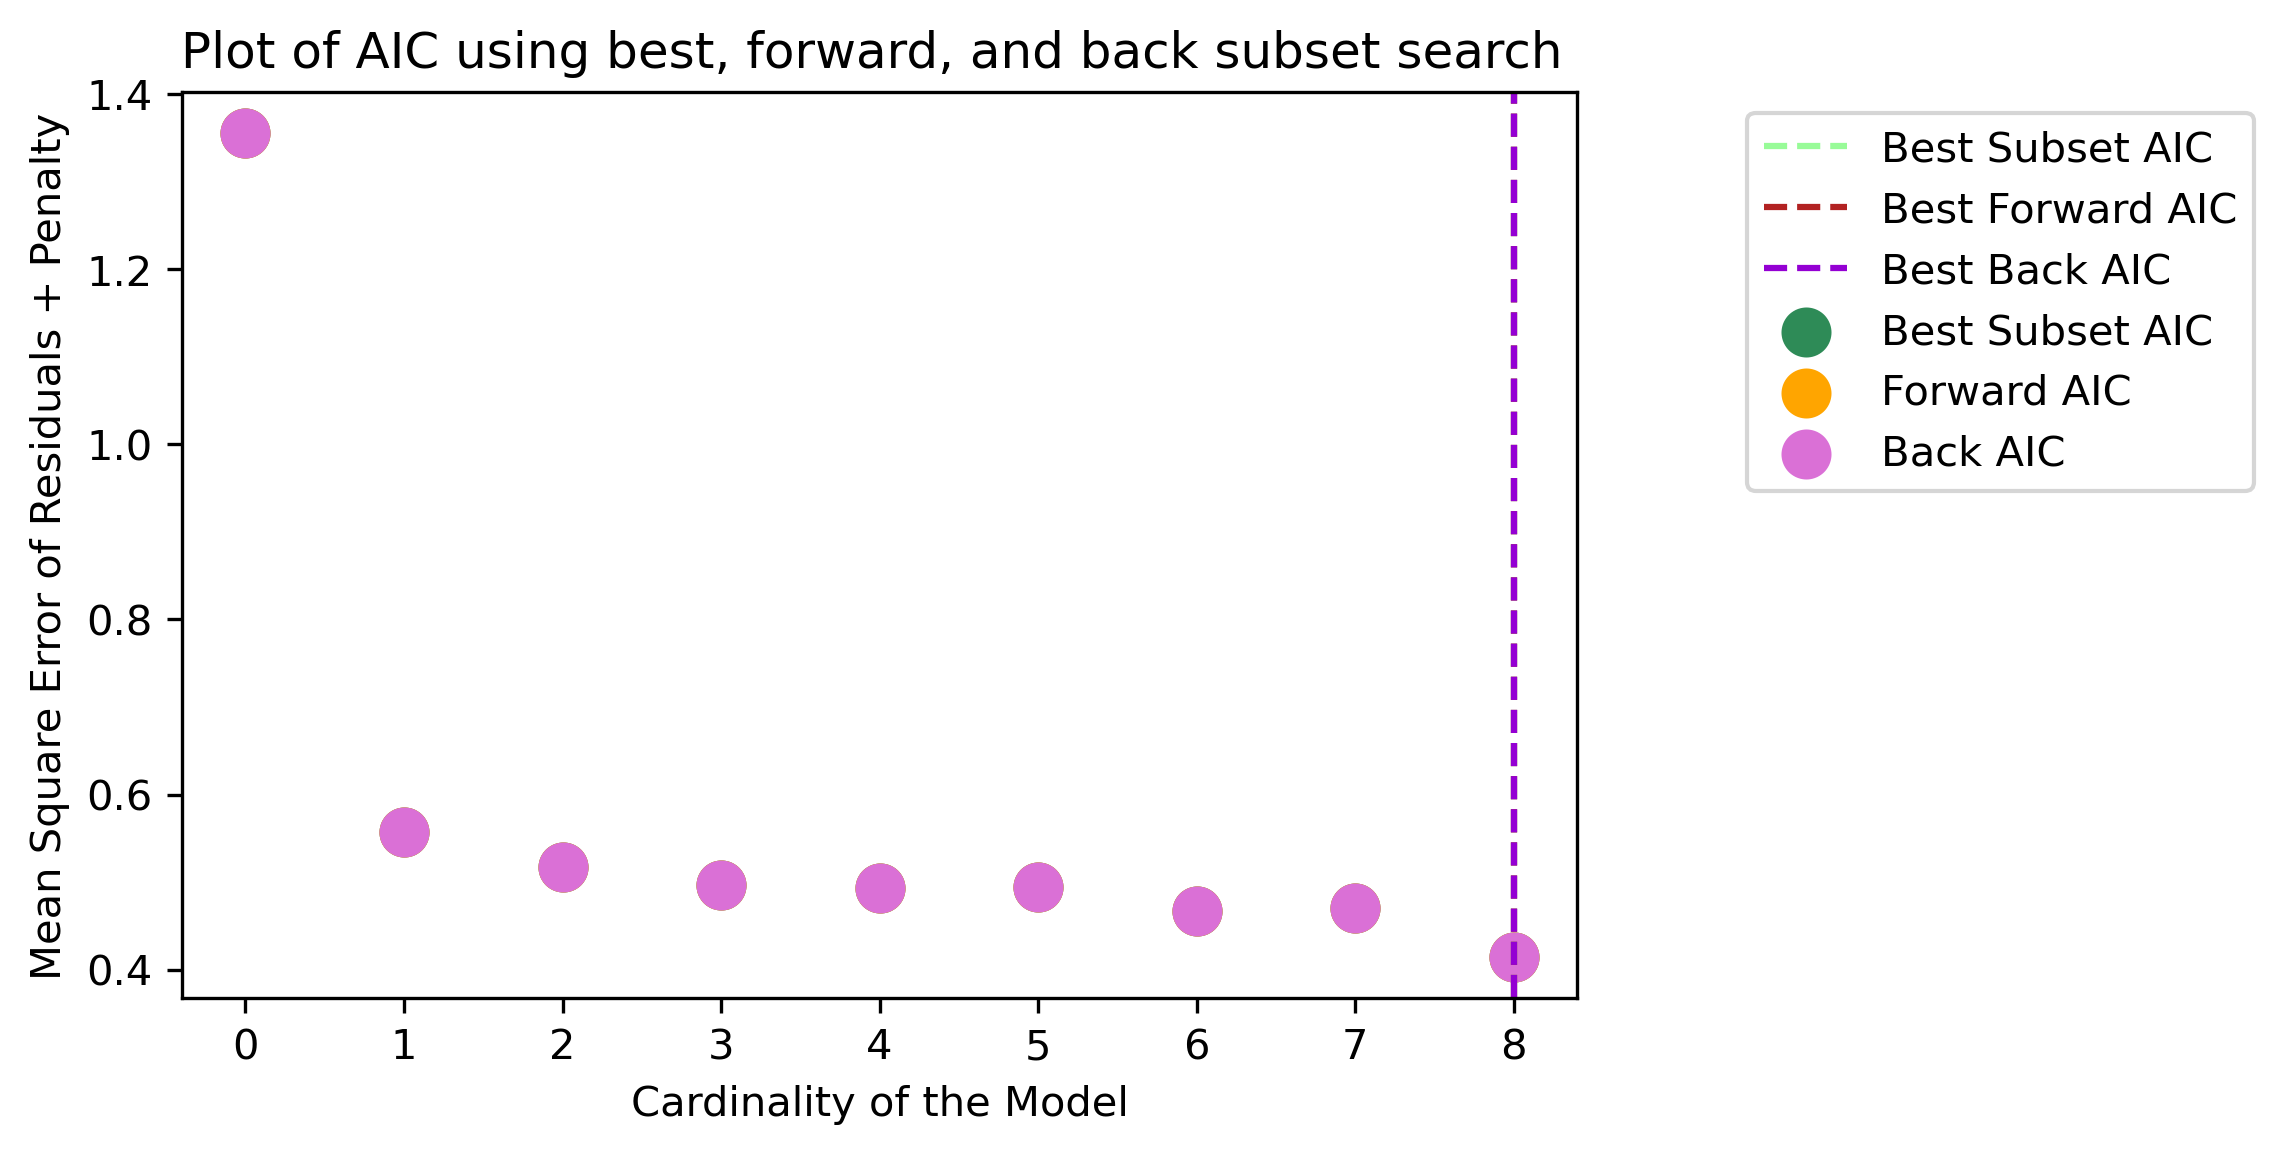

In [341]:
plt.figure()
cardinalities = range(p+1)
plt.scatter(cardinalities, AIC_vals,color='seagreen',linewidth=6,label='Best Subset AIC')
plt.scatter(cardinalities, fAIC_vals,color='orange',linewidth=6,label='Forward AIC')
plt.scatter(cardinalities, bAIC_vals,color='orchid',linewidth=6,label='Back AIC')
plt.title('Plot of AIC using best, forward, and back subset search ')
plt.xlabel("Cardinality of the Model")
plt.ylabel("Mean Square Error of Residuals + Penalty")


#Mark the value of the best AIC
plt.axvline(AIC_vals.index(min(AIC_vals)), linestyle='--', \
            color='palegreen',label=r'Best Subset AIC')
plt.axvline(fAIC_vals.index(min(fAIC_vals)), linestyle='--', \
            color='firebrick',label=r'Best Forward AIC')
plt.axvline(bAIC_vals.index(min(bAIC_vals)), linestyle='--', \
            color='darkviolet',label=r'Best Back AIC')

#plt.ylim(0,50)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
# plt.xlim(-0.5, p+10)
plt.show()

All my models had the same subsets so the AIC for all the models were the same for each method.  The AIC went continuosly went down as the cardinality went up with the AIC being the lowest for using all 8 features while the one using 0 was higher than all of the other cardinalities by a large factor.

# D

Text(0.5, 1.0, 'Cross-validated MSE as a function of λ for Lasso')

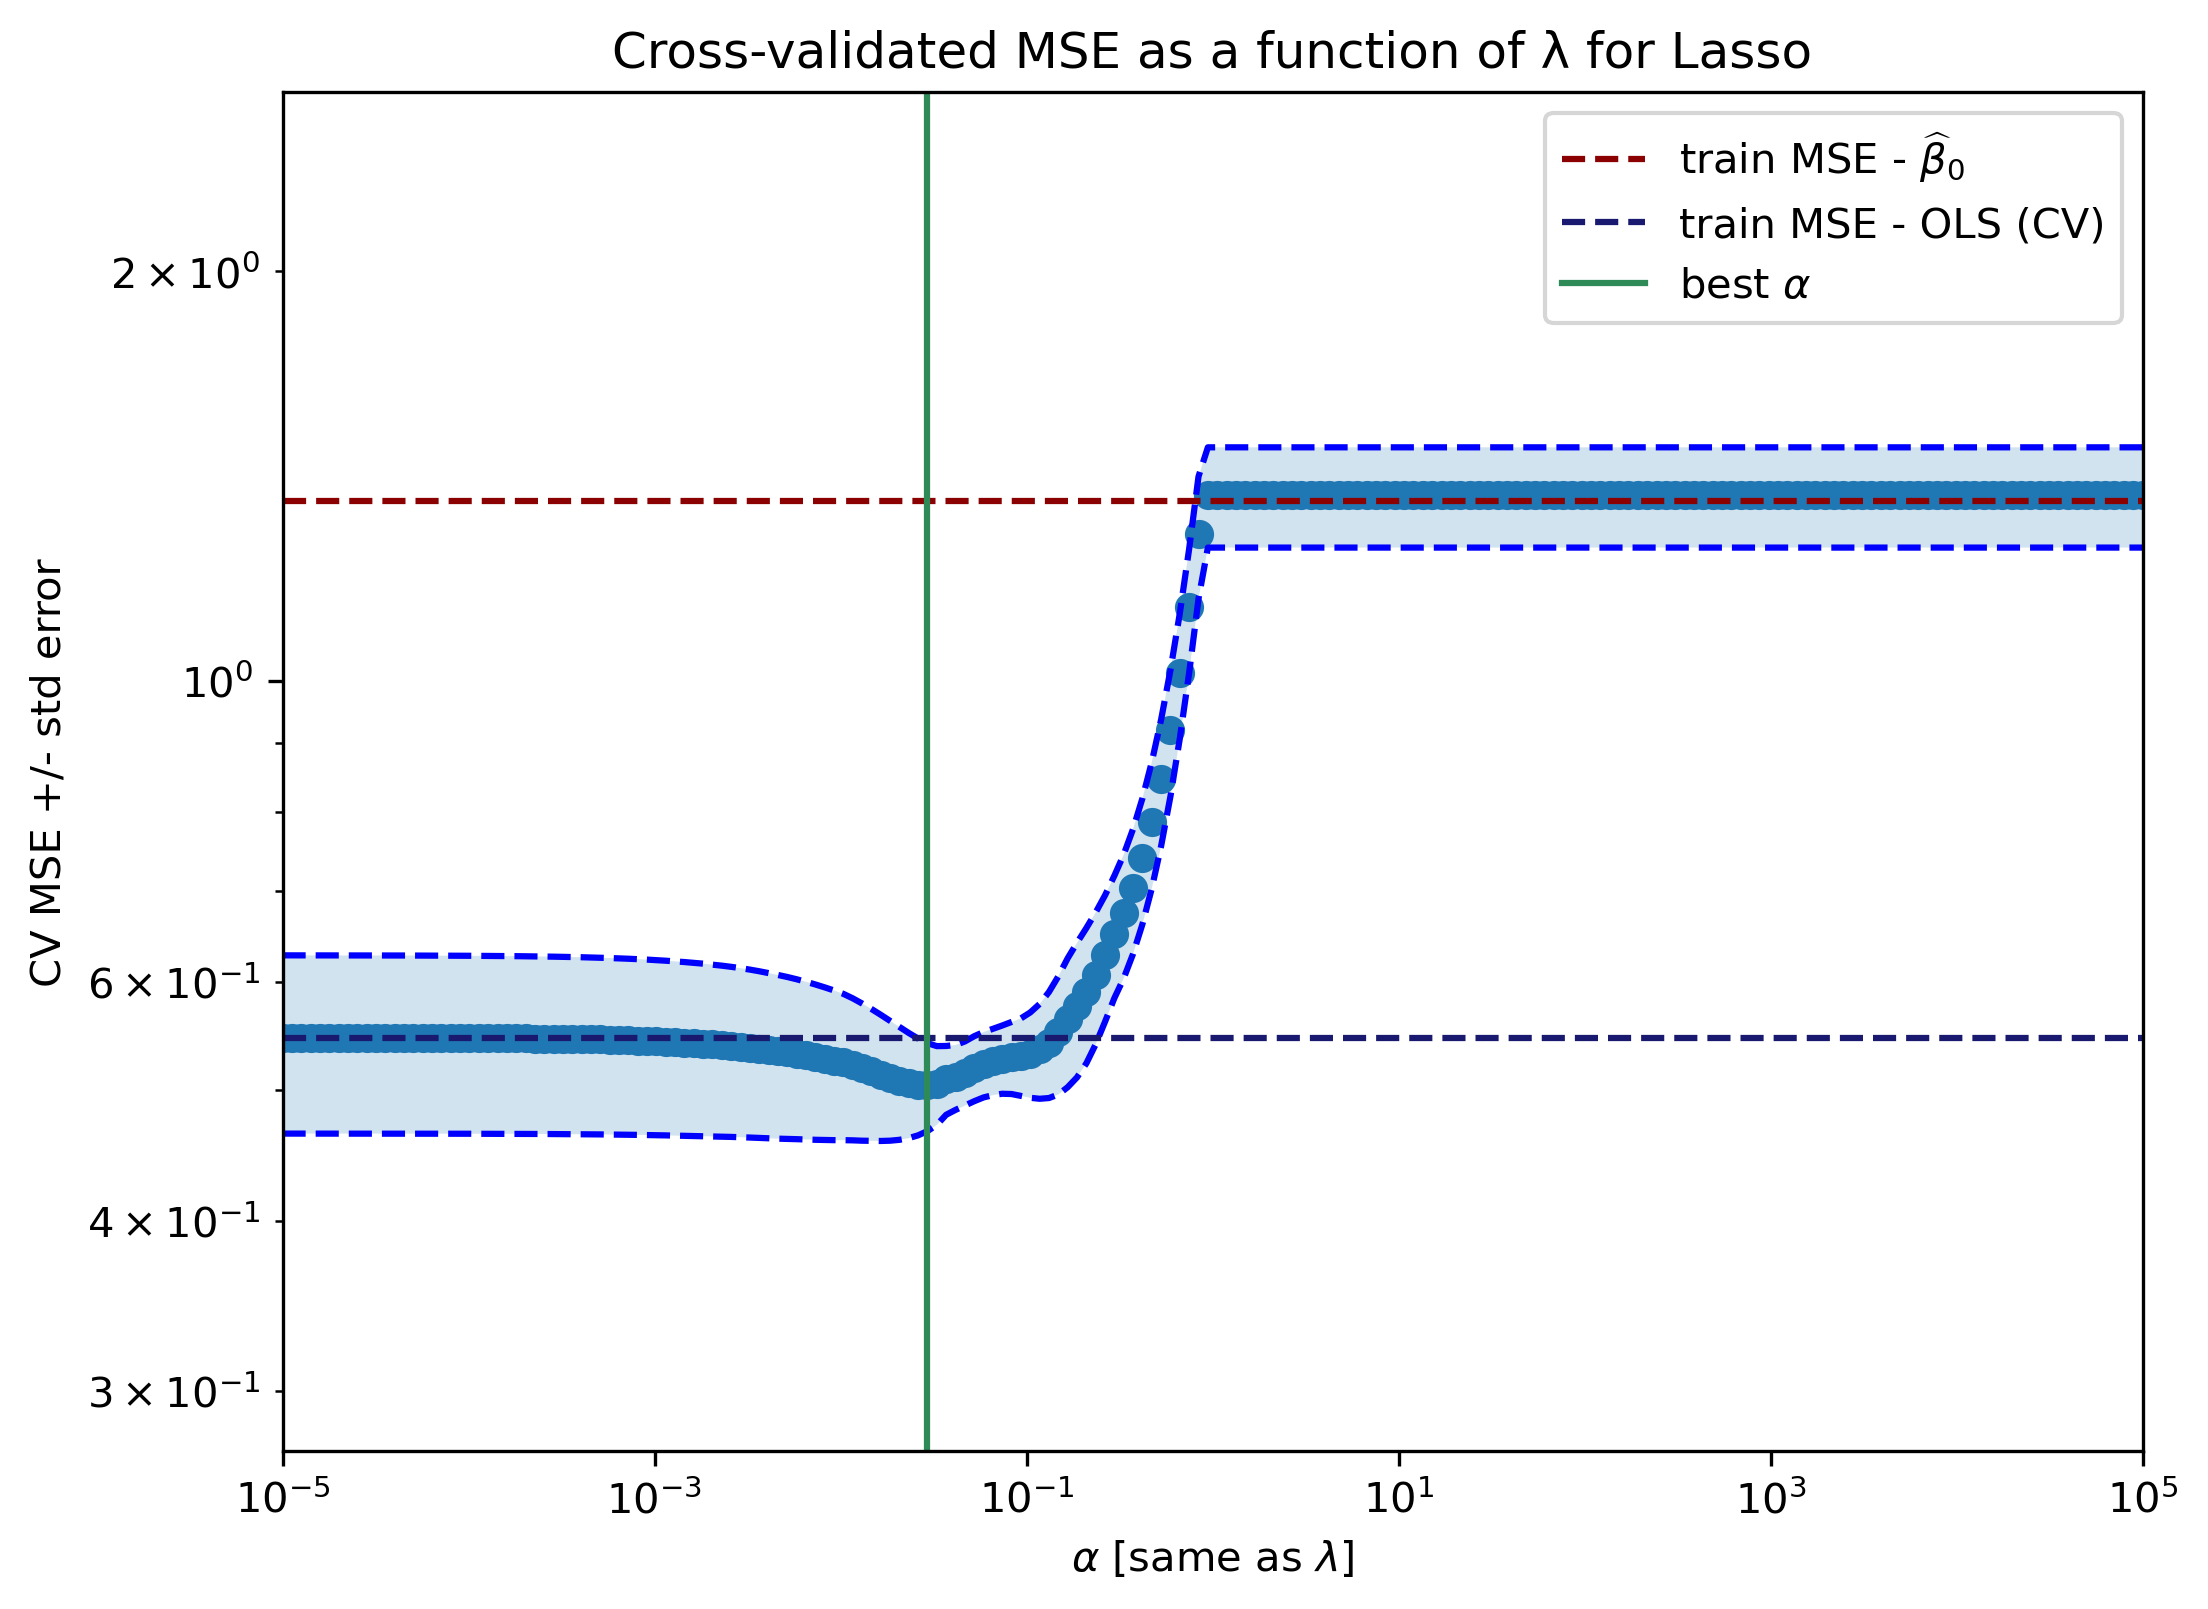

In [352]:
lscores = -lgs.cv_results_['mean_test_score']
lscores_std = lgs.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.loglog(alphas, lscores,'o')

# plot error lines showing +/- std. errors of the scores
lstd_error = lscores_std / np.sqrt(n_folds)

plt.loglog(alphas, lscores + lstd_error, 'b--')
plt.loglog(alphas, lscores - lstd_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, lscores + lstd_error, lscores - lstd_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$ [same as $\lambda$]')


#plot baseline fits for training set
#just intercept
plt.axhline(mse_train_just_intercept, linestyle='--',\
            color='darkred', \
            label=r'train MSE - $\widehat{\beta}_0$')


#OLS solution (no penalty-- all features)
plt.axhline(mse_train_OLS_CV, linestyle='--', \
            color='midnightblue',label='train MSE - OLS (CV)')

#Mark the value of the best $\alpha$
plt.axvline(alphas[lscores.argmin()], linestyle='-', \
            color='seagreen',label=r'best $\alpha$')
plt.xlim([alphas[0], alphas[-1]])
plt.ylim(mse_train_just_intercept*.2, 2*mse_train_just_intercept)
plt.legend()
plt.title('Cross-validated MSE as a function of λ for Lasso')

Text(0.5, 1.0, 'Cross-validated MSE as a function of λ for Ridge')

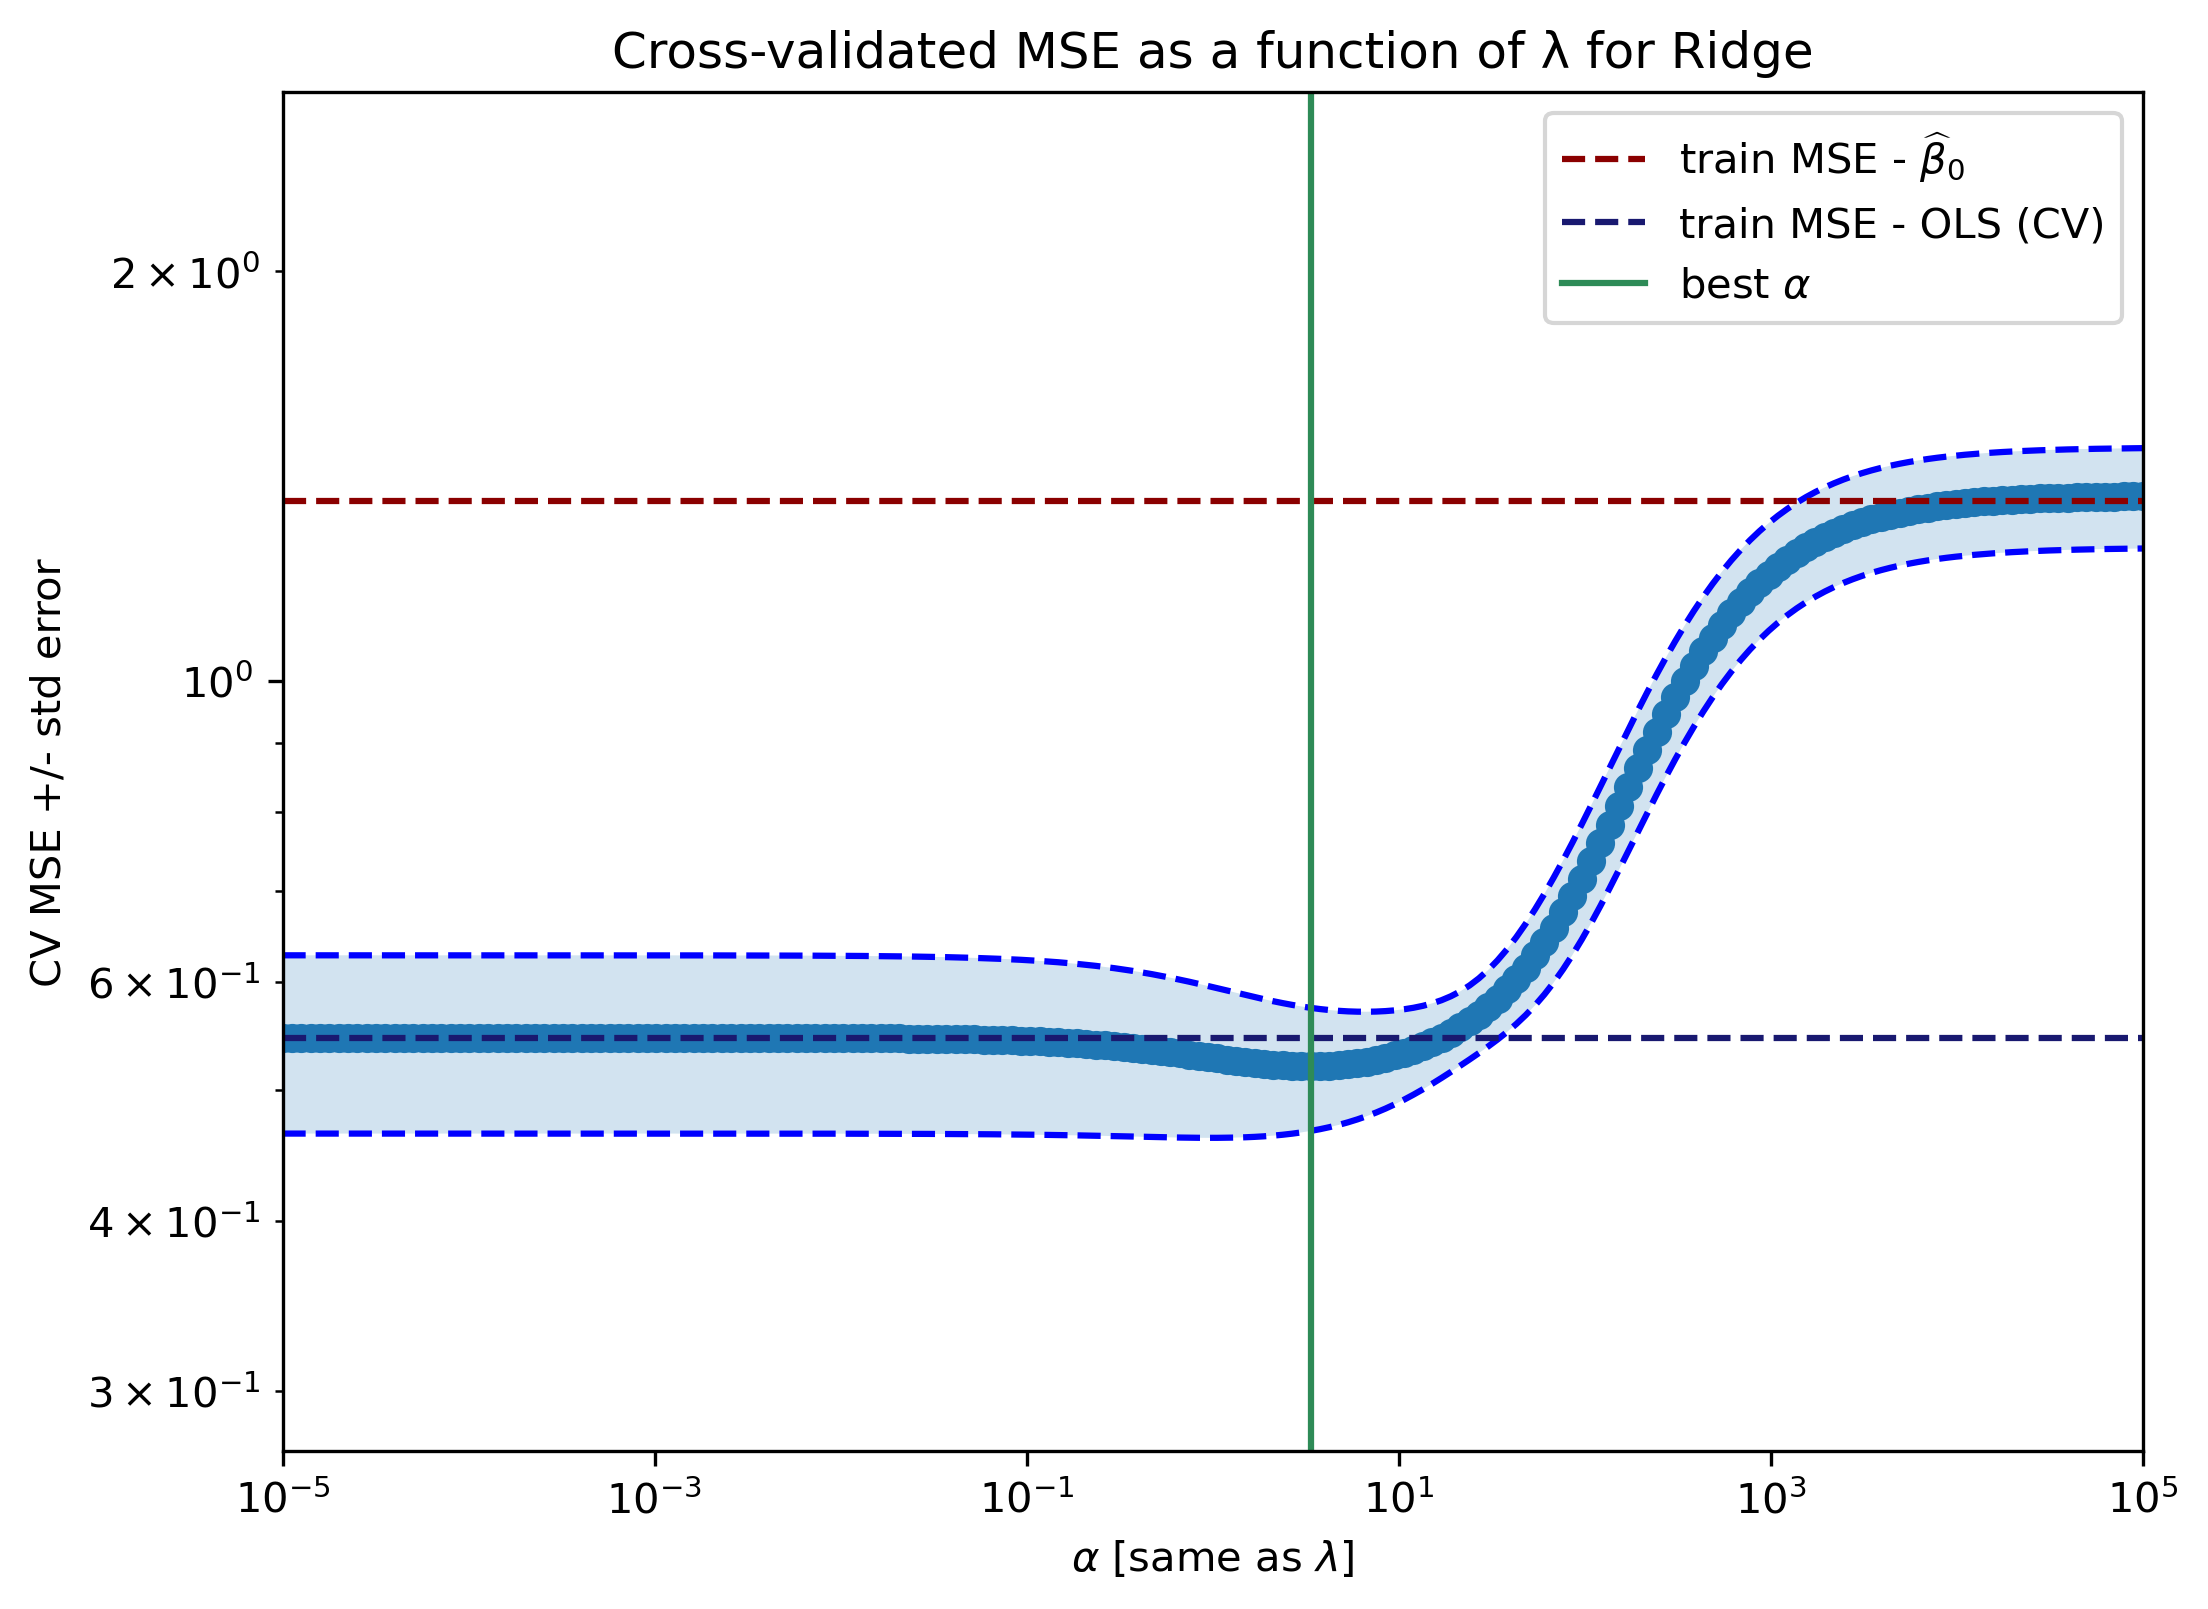

In [353]:
rscores = -rgs.cv_results_['mean_test_score']
rscores_std = rgs.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.loglog(alphas, rscores,'o')

# plot error lines showing +/- std. errors of the scores
rstd_error = rscores_std / np.sqrt(n_folds)

plt.loglog(alphas, rscores + rstd_error, 'b--')
plt.loglog(alphas, rscores - rstd_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, rscores + rstd_error, rscores - rstd_error, alpha=0.2)

plt.ylabel('CV MSE +/- std error')
plt.xlabel(r'$\alpha$ [same as $\lambda$]')


#plot baseline fits for training set
#just intercept
plt.axhline(mse_train_just_intercept, linestyle='--',\
            color='darkred', \
            label=r'train MSE - $\widehat{\beta}_0$')


#OLS solution (no penalty-- all features)
plt.axhline(mse_train_OLS_CV, linestyle='--', \
            color='midnightblue',label='train MSE - OLS (CV)')

#Mark the value of the best $\alpha$
plt.axvline(alphas[rscores.argmin()], linestyle='-', \
            color='seagreen',label=r'best $\alpha$')
plt.xlim([alphas[0], alphas[-1]])
plt.ylim(mse_train_just_intercept*.2, 2*mse_train_just_intercept)
plt.legend()
plt.title('Cross-validated MSE as a function of λ for Ridge')

Both models had similar shape and both start off following the OLS model then when it gets to the best lambda for the model it sitches to following the intercept model.  Where the 2 models differ is that the switch between OLS and intercept model is much more gradual for the Ridge model while the Lasso model is about 3 times as sharp.

# E

In [316]:
#Split up the big data set into a test set (for final evaluation) and a training set
XX_train, XX_test, yy_train, yy_test = train_test_split( X, y, train_size=5000, random_state=1)

## Ordinary Least Square (OLS)

In [317]:
scaler = StandardScaler()
lin = LinearRegression(normalize=False,fit_intercept=True) 
pipe = make_pipeline(scaler, lin)

pipe.fit(XX_train,yy_train)
mse_test_OLS = mean_squared_error(yy_test, pipe.predict(XX_test))

print('\nTest set MSE using OLS solution: %.2f'%mse_test_OLS)


Test set MSE using OLS solution: 0.53


In [318]:
cols = list(housing.feature_names)
print('Subset of features in OLS:')
print(cols)

Subset of features in OLS:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Best Intercept

In [323]:
yy_pred = np.ones(yy_test.shape)*(np.mean(yy_train))
mse_test_best_intercept = mean_squared_error(yy_test,yy_pred)

print('\nTest set MSE using Best Intercept: %.2f'%mse_test_best_intercept)


Test set MSE using Best Intercept: 1.33


In [324]:
print('\nBest Intercept used zero features')
cols = list()
print('Subset of features in Best Intercept:')
print(cols)


Best Intercept used zero features
Subset of features in Best Intercept:
[]


## Lasso 

In [345]:
n_folds = 5 #number of folds
 
n_alphas = 200  #how many lambdas to check
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

parameters = { 'lasso__alpha':alphas}
scaler = StandardScaler()
lasso = Lasso(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, lasso)

gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)#grid search
gs.fit(XX_train,yy_train)

best_alpha = gs.best_params_['lasso__alpha'] #get best alpha

scaler = StandardScaler()
lasso = Lasso(alpha=best_alpha,normalize=False,fit_intercept=True)#pass through best alpha
pipe = make_pipeline(scaler, lasso)
pipe.fit(XX_train, yy_train)

best_coef_lassos = pipe.named_steps['lasso'].coef_ #get coeffiecent values


yy_pred = pipe.predict(XX_test)
mse_test_using_lasso = mean_squared_error(yy_test,yy_pred)

print('\nTest set MSE using Lasso : %.2f'%mse_test_using_lasso)


Test set MSE using Lasso : 0.75


In [346]:
cols = list()
rn = range(len(housing.feature_names))
for i in rn:
    if abs(best_coef_lassos[i]) > 0:
        cols.append(housing.feature_names[i])

print('Subset of features in Lasso:')
print(cols)

Subset of features in Lasso:
['MedInc']


## Ridge -- (Model fit)

In [344]:
n_folds = 5 #number of folds
n_alphas = 200 #number of lambdas to check
alphas = np.logspace(-5, 5, n_alphas) #grid search for lambda (aka 'alpha')

scaler = StandardScaler()
ridge = Ridge(normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, ridge)
parameters = { 'ridge__alpha':alphas}
coefs = []

for a in alphas:
    pipe.set_params(ridge__alpha=a)
    pipe.fit(XX_train, yy_train)
    coefs.append(pipe.named_steps['ridge'].coef_)
    
gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)#grid search for lambda
gs.fit(XX_train,yy_train)

best_coef_ridge = pipe.named_steps['ridge'].coef_

yy_pred = gs.predict(XX_test)
mse_test_using_ridge = mean_squared_error(yy_test,yy_pred)
print('\nTest set MSE using Ridge: %.2f'%mse_test_using_ridge)


Test set MSE using Ridge: 1.09


In [333]:
cols = list()
rn = range(len(housing.feature_names))
for i in rn:
    if abs(best_coef_ridge[i]) > 0:
        cols.append(housing.feature_names[i])

print('Subset of features in Ridge:')
print(cols)

Subset of features in Ridge:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Exhaustive search (best subset search)

In [334]:
model = make_pipeline(StandardScaler(), LinearRegression())

#keep a dictionary, with key as the cardinality and value as 
#  a dictionary with values 'features' (list) and 'trainMSE' (float)
#  initialize with empty set (intercept), calculated above
subsets = {}
subsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = XX_train[:,c]
    
        model.fit(a,yy_train)
        m = mean_squared_error(yy_train, model.predict(a))

n_train_samples = XX_train.shape[0]
noise_var_estimate = m
    
for subset in powerset(list_features):
       
    if len(subset)==0:
        subsets[0]['AICpenalty'] = 0
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in subset) #adjust indexing
    
    X_train_subset = XX_train[:,cols]
    X_test_subset = XX_test[:,cols]
    
    model.fit(X_train_subset,yy_train)
    mse_train = mean_squared_error(yy_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(yy_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(subset)
    
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    
    if k not in list(subsets.keys()):
        #add as currently best
        subsets[k] = {'features':subset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if subsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            subsets[k] = {'features':subset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
            

In [335]:
for k in range(p+1):
    subset = subsets[k]['features']
    mse_test = subsets[k]['testMSE']
    AIC_penalty= subsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(subset)), end='')   
    for i in subset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.70   0.00  (1,) (MedInc )

  2  0.66   0.00  (1, 2) (MedInc HouseAge )

  3  0.65   0.00  (1, 2, 3) (MedInc HouseAge AveRooms )

  4  0.62   0.00  (1, 2, 3, 4) (MedInc HouseAge AveRooms AveBedrms )

  5  0.62   0.00  (1, 2, 3, 4, 5) (MedInc HouseAge AveRooms AveBedrms Population )

  6  0.62   0.00  (1, 2, 3, 4, 5, 6) (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  0.61   0.00  (1, 2, 3, 4, 5, 6, 7) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  0.53   0.00  (1, 2, 3, 4, 5, 6, 7, 8) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


## Forward Search

In [336]:
model = make_pipeline(StandardScaler(), LinearRegression())
fsubsets = {}
fsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = XX_train[:,c]
    
        model.fit(a,yy_train)
        m = mean_squared_error(yy_train, model.predict(a))

n_train_samples = XX_train.shape[0]
noise_var_estimate = m

for fsubset in powerset(list_features):
       
    if len(fsubset)==0:
        fsubsets[0]['AICpenalty'] = 0
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in fsubset) #adjust indexing
    
    X_train_subset = XX_train[:,cols]
    X_test_subset = XX_test[:,cols]
    
    model.fit(X_train_subset,yy_train)
    mse_train = mean_squared_error(yy_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(yy_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(fsubset)
    if(k>1):
        l = list(fsubset)
        prev = list(fsubsets[k-1]['features'])
        check =  all(item in l for item in prev)
        if(not check):
            continue
            
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
    
    if k not in list(fsubsets.keys()):
        #add as currently best
        fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if fsubsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            fsubsets[k] = {'features':fsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}

In [337]:
for k in range(p+1):
    fsubset = fsubsets[k]['features']
    mse_test = fsubsets[k]['testMSE']
    AIC_penalty= fsubsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(fsubset)), end='')   
    for i in fsubset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.70   0.00  (1,) (MedInc )

  2  0.66   0.00  (1, 2) (MedInc HouseAge )

  3  0.65   0.00  (1, 2, 3) (MedInc HouseAge AveRooms )

  4  0.62   0.00  (1, 2, 3, 4) (MedInc HouseAge AveRooms AveBedrms )

  5  0.62   0.00  (1, 2, 3, 4, 5) (MedInc HouseAge AveRooms AveBedrms Population )

  6  0.62   0.00  (1, 2, 3, 4, 5, 6) (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  0.61   0.00  (1, 2, 3, 4, 5, 6, 7) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  0.53   0.00  (1, 2, 3, 4, 5, 6, 7, 8) (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


## Backward Search

In [338]:
bsubsets = {}
bsubsets[0] = {'features':(), 'trainMSE':mse_train_just_intercept,\
              'AICpenalty':mse_train_just_intercept, 'testMSE':mse_train_just_intercept}  

for subset in powerset(list_features):
       
    if len(subset)==p:
        c = tuple(i-1 for i in subset) #adjust indexing
        a = XX_train[:,c]
    
        model.fit(a,yy_train)
        m = mean_squared_error(yy_train, model.predict(a))

n_train_samples = XX_train.shape[0]
noise_var_estimate = m



for bsubset in rpowerset_generator(list_features, True):
       
    if len(bsubset)==0:
        continue # for the empty set, skip to next subset
    
    #first just use columns corresponding to this feature 
    cols = tuple(i-1 for i in bsubset) #adjust indexing
    
    X_train_subset = XX_train[:,cols]
    X_test_subset = XX_test[:,cols]
    
    model.fit(X_train_subset,yy_train)
    mse_train = mean_squared_error(yy_train, model.predict(X_train_subset))
    mse_test = mean_squared_error(yy_test, model.predict(X_test_subset))
    
    #update if this is the best seen of this cardinality
    k = len(bsubset)
    if(k<p):
        prev = list(bsubsets[k+1]['features'])
        l = list(bsubset)
        check = all(item in prev for item in l)
        if(not check):
            continue
            
    AIC_penalty = 2*k*noise_var_estimate/n_train_samples
            
    if k not in list(bsubsets.keys()):
        #add as currently best
        bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
    else:
        if bsubsets[k]['AICpenalty']>AIC_penalty:
            #add as currently best
            bsubsets[k] = {'features':bsubset, 'trainMSE':mse_train, 'AICpenalty':AIC_penalty, 'testMSE':mse_test}
            
bsubsets[0]['AICpenalty'] = 0

In [339]:
for k in range(p+1):
    bsubset = bsubsets[k]['features']
    mse_test = bsubsets[k]['testMSE']
    AIC_penalty= bsubsets[k]['AICpenalty']
    
    print('\n %2i  %.2f   %.2f  %s ('%(k,mse_test,AIC_penalty,str(bsubset)), end='')   
    for i in bsubset:
        print(housing.feature_names[i-1]+ " ", end = '')
    print(')')


  0  1.36   0.00  () ()

  1  0.70   0.00  [1] (MedInc )

  2  0.66   0.00  [1, 2] (MedInc HouseAge )

  3  0.65   0.00  [1, 2, 3] (MedInc HouseAge AveRooms )

  4  0.62   0.00  [1, 2, 3, 4] (MedInc HouseAge AveRooms AveBedrms )

  5  0.62   0.00  [1, 2, 3, 4, 5] (MedInc HouseAge AveRooms AveBedrms Population )

  6  0.62   0.00  [1, 2, 3, 4, 5, 6] (MedInc HouseAge AveRooms AveBedrms Population AveOccup )

  7  0.61   0.00  [1, 2, 3, 4, 5, 6, 7] (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude )

  8  0.53   0.00  [1, 2, 3, 4, 5, 6, 7, 8] (MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude Longitude )


The biggest difference I saw was that for the subset searches the AIC for the models with 5000 were all zero because we increased the amount of samples used.  In this best subset search using all features and OLS had the lowest testMSE and then Lasso was next and Lasso decreased the coefficients it was using to just MedInc then Ridge followed by Intercept.  So as we increase the amount of elements in the training set Lasso and Ridge become much better fitting model while the subset searches are typically a good model regardless of size.